In [1]:
import librosa
import pandas as pd
import numpy as np 
import string
import matplotlib.pyplot as plt
import torch 
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pathlib
from PIL import Image
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import os

Using TensorFlow backend.


In [2]:
# Converting audio to PNG format images
cmap = plt.get_cmap('inferno')
rapsong = "Afroman - Colt 45-rNtiEcT9W6M.mp3"
sr = 2000#44100 #22050
duration = 15
y_rap, sr = librosa.load(rapsong, sr= sr, duration=duration, offset=60, mono=True)
print(sr)
print(y_rap.shape)
plt.specgram(y_rap, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');

C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: 'Afroman - Colt 45-rNtiEcT9W6M.mp3'

In [ ]:
countrysong = "Aaron Lewis - 'Country Boy' (Official Video)-vsQzw_Ax8Cw.mp3"
y_country, sr = librosa.load(countrysong, sr= sr ,duration=duration,offset=60, mono=True)
plt.specgram(y_country, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');

In [4]:
spec_cent = [] # spectral centroid 
mfcc = []
spec_bw = []
rolloff = []  # spetral rolloff
zcr = [] 
chroma_stft = [] 
rmse = []
for y in [y_rap, y_country]:
    rmse.append(librosa.feature.rms(y=y))
    chroma_stft.append(librosa.feature.chroma_stft(y=y, sr=sr))
    spec_cent.append(librosa.feature.spectral_centroid(y=y, sr=sr))
    spec_bw.append(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff.append(librosa.feature.spectral_rolloff(y=y, sr=sr))
    zcr.append(librosa.feature.zero_crossing_rate(y))
    mfcc.append(librosa.feature.mfcc(y=y, sr=sr))

In [5]:
y_rap.shape

(5000,)

In [6]:
y_country.shape

(5000,)

In [7]:
rmse[1].shape

(1, 10)

In [8]:
chroma_stft[0].shape

(12, 10)

In [9]:
spec_bw[1].shape

(1, 10)

In [10]:
rolloff[1].shape

(1, 10)

In [11]:
zcr[1].shape

(1, 10)

In [12]:
mfcc[1].shape

(20, 10)

In [13]:
import soundfile as sf
test = sf.read("C:\\Users\\bleul\\anaconda3\\envs\\gpu\\Lib\\site-packages\\IPython\\lib\\tests\\test.wav", )

In [14]:
test[0].shape

(22050,)

In [15]:
librosa.load("C:\\Users\\bleul\\anaconda3\\envs\\gpu\\Lib\\site-packages\\IPython\\lib\\tests\\test.wav", sr= sr)[0].shape

(500,)

In [16]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [593]:
country_lyrics = load_doc("Aaron Lewis  -  'Country Boy' .txt")
rap_lyrics= load_doc("Afroman  -  Colt 45.txt")

In [594]:
rap_lyrics

'\nWait a minute, man, hey, check this out, man (Tell it)\nIt was this blind man, right? (This man) It was this blind man, right?\nHe was feelin\' his way down the street with a stick, right? (Hey)\nHe walked past this fish market, you know what I\'m sayin\'?\n(Fish market?) He stopped, he took a deep breath, he said\n*sniffs* "Woo good morning ladies" (Hahahahaha)\nYou like that shit, man? Hey man, I\'ve got a gang of that shit, man\nHey, I\'ll tell you what, we\'ll all have a good time\nWe\'ll fool on the drum, and hey\nHey if everybody crowd around the mic\'\nI\'ll tell you all these motherfuckin\' jokes I got\nFirst I\'m gonna start off like that, hey help me sing it, homeboy\n\n\nSaid Colt 45 and two Zig-Zags, baby, that\'s all we need\nWe can go to the park, after dark, smoke that tumbleweed\nAs the marijuana burn, we can take our turn\nSingin\' them dirty rap songs\nStop and hit the bong like Cheech & Chong\nAnd sell tapes from here to Hong Kong\nSo roll, roll, roll my joint, pi

In [595]:
# get all lyrics for each song
def all_lyrics_for_audio(filenames, audio_data_paths):
    lyrics_for_audio  = {}
    for filename, audio_data_path in zip(filenames, audio_data_paths):
        file = load_doc(filename)
        lyrics = file.split('\n')[1:]
        for sentence in lyrics:
            if sentence != "":
                if audio_data_path not in lyrics_for_audio:
                    lyrics_for_audio[audio_data_path] = [sentence]
                else:
                    lyrics_for_audio[audio_data_path].append(sentence)
    return lyrics_for_audio

In [596]:
lyrics4audio = all_lyrics_for_audio(["Afroman  -  Colt 45.txt", "Aaron Lewis  -  'Country Boy' .txt"], 
                                    ["Afroman - Colt 45-rNtiEcT9W6M.mp3", "Aaron Lewis - 'Country Boy' (Official Video)-vsQzw_Ax8Cw.mp3"])

In [597]:
lyrics4audio

{'Afroman - Colt 45-rNtiEcT9W6M.mp3': ['Wait a minute, man, hey, check this out, man (Tell it)',
  'It was this blind man, right? (This man) It was this blind man, right?',
  "He was feelin' his way down the street with a stick, right? (Hey)",
  "He walked past this fish market, you know what I'm sayin'?",
  '(Fish market?) He stopped, he took a deep breath, he said',
  '*sniffs* "Woo good morning ladies" (Hahahahaha)',
  "You like that shit, man? Hey man, I've got a gang of that shit, man",
  "Hey, I'll tell you what, we'll all have a good time",
  "We'll fool on the drum, and hey",
  "Hey if everybody crowd around the mic'",
  "I'll tell you all these motherfuckin' jokes I got",
  "First I'm gonna start off like that, hey help me sing it, homeboy",
  "Said Colt 45 and two Zig-Zags, baby, that's all we need",
  'We can go to the park, after dark, smoke that tumbleweed',
  'As the marijuana burn, we can take our turn',
  "Singin' them dirty rap songs",
  'Stop and hit the bong like Che

In [598]:
#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(lyrics):
    table = str.maketrans('','',string.punctuation)
    for song,caps in lyrics.items():
        for i,song_lyric in enumerate(caps):
            song_lyric.replace("-"," ")
            desc = song_lyric.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            song_lyric = ' '.join(desc)
            lyrics[song][i]= song_lyric
    return lyrics

In [599]:
clean_lyrics = cleaning_text(lyrics4audio)
clean_lyrics

{'Afroman - Colt 45-rNtiEcT9W6M.mp3': ['wait minute man hey check this out man tell it',
  'it was this blind man right this man it was this blind man right',
  'he was feelin his way down the street with stick right hey',
  'he walked past this fish market you know what im sayin',
  'fish market he stopped he took deep breath he said',
  'sniffs woo good morning ladies hahahahaha',
  'you like that shit man hey man ive got gang of that shit man',
  'hey ill tell you what well all have good time',
  'well fool on the drum and hey',
  'hey if everybody crowd around the mic',
  'ill tell you all these motherfuckin jokes got',
  'first im gonna start off like that hey help me sing it homeboy',
  'said colt and two zigzags baby thats all we need',
  'we can go to the park after dark smoke that tumbleweed',
  'as the marijuana burn we can take our turn',
  'singin them dirty rap songs',
  'stop and hit the bong like cheech chong',
  'and sell tapes from here to hong kong',
  'so roll roll r

In [600]:
def insert_tokens(clean_lyrics):
    for key, sentences in clean_lyrics.items():
        temp = [] 
        for sentence in sentences:
            temp_sentence = '<start> ' + sentence + ' <end>'
            temp.append(temp_sentence)
        clean_lyrics[key] = temp
    return clean_lyrics

In [601]:
clean_lyrics = insert_tokens(clean_lyrics)
clean_lyrics

{'Afroman - Colt 45-rNtiEcT9W6M.mp3': ['<start> wait minute man hey check this out man tell it <end>',
  '<start> it was this blind man right this man it was this blind man right <end>',
  '<start> he was feelin his way down the street with stick right hey <end>',
  '<start> he walked past this fish market you know what im sayin <end>',
  '<start> fish market he stopped he took deep breath he said <end>',
  '<start> sniffs woo good morning ladies hahahahaha <end>',
  '<start> you like that shit man hey man ive got gang of that shit man <end>',
  '<start> hey ill tell you what well all have good time <end>',
  '<start> well fool on the drum and hey <end>',
  '<start> hey if everybody crowd around the mic <end>',
  '<start> ill tell you all these motherfuckin jokes got <end>',
  '<start> first im gonna start off like that hey help me sing it homeboy <end>',
  '<start> said colt and two zigzags baby thats all we need <end>',
  '<start> we can go to the park after dark smoke that tumblewee

In [602]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [603]:
vocab = text_vocabulary(clean_lyrics)
vocab_size = len(vocab)
vocab

{'<end>',
 '<start>',
 'above',
 'across',
 'afford',
 'african',
 'afro',
 'afroman',
 'after',
 'again',
 'aiee',
 'aint',
 'albino',
 'alive',
 'all',
 'already',
 'always',
 'amazed',
 'america',
 'american',
 'an',
 'and',
 'anybody',
 'are',
 'around',
 'as',
 'asks',
 'ass',
 'at',
 'ate',
 'attitudes',
 'australia',
 'ay',
 'ayy',
 'baby',
 'back',
 'bag',
 'be',
 'beat',
 'beating',
 'beautiful',
 'because',
 'bed',
 'been',
 'before',
 'beliefs',
 'best',
 'bet',
 'better',
 'big',
 'bigger',
 'biggest',
 'bitch',
 'black',
 'blend',
 'blind',
 'bloody',
 'blue',
 'bong',
 'border',
 'bottle',
 'boy',
 'boyfriend',
 'breakfast',
 'breath',
 'bucks',
 'burn',
 'busted',
 'but',
 'butt',
 'caddy',
 'cadillac',
 'call',
 'came',
 'can',
 'cant',
 'carolina',
 'catch',
 'cause',
 'cds',
 'change',
 'chasin',
 'check',
 'cheech',
 'chevrolet',
 'chicken',
 'chong',
 'clothes',
 'colonel',
 'colors',
 'colt',
 'coma',
 'come',
 'corner',
 'could',
 'country',
 'coupe',
 'couple',
 

In [604]:
len(vocab)

515

In [605]:
from keras.preprocessing.text import Tokenizer
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [606]:
token = create_tokenizer(clean_lyrics)
token.word_index

{'start': 1,
 'end': 2,
 'the': 3,
 'and': 4,
 'my': 5,
 'to': 6,
 'in': 7,
 'you': 8,
 'her': 9,
 'that': 10,
 'this': 11,
 'it': 12,
 'on': 13,
 'he': 14,
 'was': 15,
 'all': 16,
 'me': 17,
 'we': 18,
 'roll': 19,
 'but': 20,
 'so': 21,
 'man': 22,
 'said': 23,
 'like': 24,
 'of': 25,
 'met': 26,
 'fucked': 27,
 'your': 28,
 'can': 29,
 'just': 30,
 'she': 31,
 'is': 32,
 'ill': 33,
 'thats': 34,
 'out': 35,
 'as': 36,
 'sell': 37,
 'from': 38,
 'up': 39,
 'cause': 40,
 'hey': 41,
 'go': 42,
 'tapes': 43,
 'country': 44,
 'now': 45,
 'right': 46,
 'with': 47,
 'got': 48,
 'if': 49,
 'two': 50,
 'need': 51,
 'smoke': 52,
 'take': 53,
 'white': 54,
 'ass': 55,
 'pussy': 56,
 'be': 57,
 'boy': 58,
 'tell': 59,
 'down': 60,
 'know': 61,
 'good': 62,
 'ive': 63,
 'well': 64,
 'colt': 65,
 'zigzags': 66,
 'baby': 67,
 'park': 68,
 'after': 69,
 'dark': 70,
 'tumbleweed': 71,
 'our': 72,
 'rap': 73,
 'songs': 74,
 'here': 75,
 'through': 76,
 'dont': 77,
 'haha': 78,
 'ever': 79,
 'come': 8

In [607]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(clean_lyrics)
max_length

23

In [644]:
input_audio = np.asarray([[y_rap, y_country]]).squeeze()
# scaler = StandardScaler().fit(input_audio)
# input_audio = scaler.transform(input_audio)
input_audio.shape

(2, 30000)

In [645]:
audio = {}
for i, key in enumerate(clean_lyrics.keys()):
    audio[key]= input_audio[i,:].reshape(1, -1)

In [646]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            print(key)
            yield [[input_image, input_sequence], output_word]
                   
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq-1], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [647]:
list_input_audio = []
list_input_text = []
list_output_text = []

for key,_ in audio.items():
    input_audio, input_text, output_text = create_sequences(token, max_length, 
                                            clean_lyrics[key], audio[key])
    list_input_audio.append(input_audio)
    list_input_text.append(input_text)
    list_output_text.append(output_text)
input_audio = np.concatenate(list_input_audio)
input_text = np.concatenate(list_input_text)
output_text = np.concatenate(list_output_text)

In [648]:
# [input_audio, input_text], output_text = next(data_generator(clean_lyrics, audio, token, max_length))

# [input_audio, input_text], output_text = next(data_generator(clean_lyrics, audio, token, max_length))

# [input_audio, input_text], output_text = next(data_generator(clean_lyrics, audio, token, max_length))
input_audio.shape, input_text.shape, output_text.shape

((1696, 1, 30000), (1696, 23), (1696, 515))

In [690]:
class audioFeatureExtractor(torch.nn.Module):
    def __init__(self, vocab_size, filter_list, ks_list, stride_list, seq_len, max_len,
                 padding=1,
                embedding_size=8, input_size=1, latent_dim=256, n_operations=3):
        torch.nn.Module.__init__(self)
        self.input_size = input_size
        self.word_embedding_dim = embedding_size
        self.vocab_size = vocab_size
        self.latent_dim = latent_dim
        self.out_channels = filter_list
        self.ks_list = ks_list   
        self.stride_list= stride_list
        self.sequence_length = seq_len
        self.compute_window_size()
        Wn = self.sequence_length
        self.lstm_dim = 50
        for i in range(n_operations):
            for j in range(2):
                if j == 0:
                    Wn = (Wn-self.ks_list[i])//self.stride_list[i] + 1
                else:
                    Wn = (Wn-self.ks_list[i])//self.ks_list[i] + 1 
        self.Wn = Wn
        # Handling Audio
        self.layer1 = torch.nn.Sequential(torch.nn.Conv1d(in_channels=input_size,
                                                         out_channels=filter_list[0],
                                                         kernel_size = ks_list[0],
                                                         stride=stride_list[0],
#                                                          padding= 1,
                                                         ),
                                              
                        torch.nn.BatchNorm1d(filter_list[0]),
                        torch.nn.ReLU(),
                        torch.nn.MaxPool1d(ks_list[0],
#                                           padding=1
                                          )
        )
        
        self.layer2 = torch.nn.Sequential(torch.nn.Conv1d(in_channels=filter_list[0],
                                                         out_channels=filter_list[1],
                                                         kernel_size = ks_list[1],
                                                         stride=stride_list[1]),
                        torch.nn.BatchNorm1d(filter_list[1]),
                        torch.nn.ReLU(),
                        torch.nn.MaxPool1d(ks_list[1])
        )
        
        self.layer3 = torch.nn.Sequential(torch.nn.Conv1d(in_channels=filter_list[1],
                                                         out_channels=filter_list[2],
                                                         kernel_size = ks_list[2],
                                                         stride=stride_list[2]),
                        torch.nn.BatchNorm1d(filter_list[2]),
                        torch.nn.ReLU(),
                        torch.nn.MaxPool1d(ks_list[2])
        )
        
        self.dense = torch.nn.Linear(in_features=filter_list[2]*self.Wn, 
                                     out_features=latent_dim)
        self.relu = torch.nn.ReLU()
        
        # Text 
        self.embedding = torch.nn.Embedding(self.vocab_size, self.word_embedding_dim)
        self.pos_embedding = torch.nn.Embedding(max_len, self.word_embedding_dim)
        self.lstm1 = torch.nn.LSTM(input_size=self.word_embedding_dim,
                            hidden_size=self.lstm_dim,
                            batch_first=True)
        
        self.lstm2 = torch.nn.LSTM(input_size=self.lstm_dim,
                            hidden_size=self.latent_dim,
                            batch_first=True)
        
        # Common 
        self.common_dense = torch.nn.Linear(in_features=latent_dim,
                                        out_features=1028)
        self.final_dense = torch.nn.Linear(1028, self.vocab_size)
        
    def forward(self, text, audio, cuda=False):
        text, audio = torch.tensor(text).type(torch.LongTensor), torch.tensor(audio)
        if cuda:
            text = text.cuda()
            audio = audio.cuda()
        if len(audio.shape) < 3:
            audio = audio.view(audio.size(0), 1, -1)
        audio_out1 = self.layer1(audio)
        audio_out2 = self.layer2(audio_out1)
        audio_out3 = self.layer3(audio_out2)
        audio_out4 = self.dense(audio_out3.view(audio.size(0), -1))
        
        text_out1 = self.embedding(text)
        pos = torch.arange(text.shape[-1])
        if cuda:
            pos = pos.cuda()
        pos_out = self.pos_embedding(pos)
        text_out2 = pos_out + text_out1
        h_0 = torch.zeros(1, audio.size(0), self.lstm_dim)
        c_0 = torch.zeros(1, audio.size(0), self.lstm_dim)#latent_dim)
        h_1 = torch.zeros(1, audio.size(0), self.latent_dim)
        c_1 = torch.zeros(1, audio.size(0), self.latent_dim)
        if len(text_out2.shape) == 2:
            text_out2 = text_out2.unsqueeze(0)
        if cuda:
            h_0 = h_0.cuda()
            c_0 = c_0.cuda()
            h_1 = h_1.cuda()
            c_1 = c_1.cuda()

        text_out3, (h_out, c_out) = self.lstm1(text_out2, (h_0, c_0))
        text_out4, (h_out, c_out) = self.lstm2(text_out3, (h_1, c_1))

        added_output = audio_out4 + h_out.view(-1, self.latent_dim)
        
        prefinal = self.relu(self.common_dense(added_output))
        final =  self.final_dense(prefinal)
        
        return final
    
    def compute_window_size(self):
        # Assuming stride = 1 and 3 CNN
        self.Wn = int((((self.sequence_length-self.ks_list[0]+1)/self.stride_list[0]\
                    - self.ks_list[1]+1)/self.stride_list[1] - self.ks_list[2]+1)/self.stride_list[2]) +1
        

In [691]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, audio, text, labels):
        'Initialization'
        self.labels = labels
        self.audio = audio
        self.text = text

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

  def __getitem__(self, index):
        'Generates one sample of data'
        return self.audio[index], self.text[index], self.labels[index]

In [692]:
ks_list = [9, 3, 3]
filter_list = [16, 32, 64]
stride_list = [4,4,4]

In [693]:
input_audio.shape[-1]

30000

In [694]:
model = audioFeatureExtractor(vocab_size, filter_list, ks_list, stride_list, embedding_size=200,
                              latent_dim=256, max_len= max_length,
                             input_size=1,seq_len = input_audio.shape[-1])

In [695]:
length  = len(input_audio)
out_Test = model(input_text, input_audio.reshape(length, 1, -1), cuda=False)
out_Test

tensor([[-1.0589e-01,  1.1975e-01, -2.1665e-01,  ...,  2.8529e-01,
          6.2502e-02,  1.0999e-01],
        [-1.0713e-01,  1.1925e-01, -2.1364e-01,  ...,  2.8763e-01,
          6.7357e-02,  1.1013e-01],
        [-9.7551e-02,  1.1821e-01, -2.2057e-01,  ...,  2.8167e-01,
          6.7976e-02,  1.1239e-01],
        ...,
        [-1.1767e-01,  1.5881e-01, -1.1633e-01,  ...,  4.4008e-02,
          1.4335e-01, -3.6844e-03],
        [-1.2295e-01,  1.6431e-01, -1.1453e-01,  ...,  4.0684e-02,
          1.4774e-01, -9.1415e-05],
        [-1.2488e-01,  1.6369e-01, -1.0951e-01,  ...,  4.1062e-02,
          1.5114e-01, -6.3439e-03]], grad_fn=<AddmmBackward>)

In [655]:
torch.argmax(out_Test, axis=1)

tensor([241, 241, 241,  ..., 419, 419, 419], grad_fn=<NotImplemented>)

In [696]:
epochs = 300
cuda = True
learning_rate = 0.001
l2 = 0.0
bsize= 32
opt = "adam"
momentum = 0.999
shuffle = False
chosen_epoch= 100

data = Dataset(input_audio, input_text, output_text)
dataloader = torch.utils.data.DataLoader(data, batch_size=bsize, shuffle=shuffle)
hist = np.zeros(epochs)
criterion = torch.nn.functional.cross_entropy


if cuda:
    model.cuda()
for epoch in range(epochs):
    if epoch ==0:
        if opt =="adam":
            optimizer = torch.optim.Adam(model.parameters(),
                                      lr=learning_rate, weight_decay=l2)
        else:
            optimizer = torch.optim.SGD(model.parameters(),
                                  lr=learning_rate, weight_decay=l2, momentum=momentum)
    elif epoch==chosen_epoch and chosen_epoch is not None:
            learning_rate = learning_rate/100
            if opt =="adam":
                optimizer = torch.optim.Adam(model.parameters(),
                                      lr=learning_rate, weight_decay=l2)
            else:
                optimizer = torch.optim.SGD(model.parameters(),
                                  lr=learning_rate, weight_decay=l2, momentum=momentum)
    hist_batch = []
    for batch_audio, batch_text, batch_text_out in dataloader:
        optimizer.zero_grad()
        output_hat = model(batch_text, batch_audio.reshape(len(batch_text), 1, -1), cuda=cuda)
        batch_text_out = torch.argmax(batch_text_out, axis=1)
        if cuda:
            batch_text_out = batch_text_out.type(torch.LongTensor).cuda()
        else:
            batch_text_out = batch_text_out.type(torch.LongTensor)
        loss =  criterion(output_hat, batch_text_out)
        hist[epoch] = loss.item()
        hist_batch.append(hist[epoch])
        loss.backward()
        optimizer.step()
    print(f"Epoch #{epoch+1}, loss={np.mean(hist_batch)}")

C:\Users\bleul\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch #1, loss=5.786534273399497
Epoch #2, loss=5.158671019212255
Epoch #3, loss=5.018969544824564
Epoch #4, loss=5.031337099255256
Epoch #5, loss=5.091109428765638
Epoch #6, loss=5.501671444694951
Epoch #7, loss=5.090643279957321
Epoch #8, loss=4.811627226055793
Epoch #9, loss=4.763230328289968
Epoch #10, loss=4.576262276127653
Epoch #11, loss=4.394072289736766
Epoch #12, loss=4.275417039979179
Epoch #13, loss=4.058235780248102
Epoch #14, loss=3.946651652174176
Epoch #15, loss=3.797612354440509
Epoch #16, loss=3.6637193346923254
Epoch #17, loss=3.378610502998784
Epoch #18, loss=3.1593375532132275
Epoch #19, loss=2.956829417426631
Epoch #20, loss=2.64313505730539
Epoch #21, loss=2.3911743996278294
Epoch #22, loss=2.3761785289026656
Epoch #23, loss=2.138945352356389
Epoch #24, loss=1.9859244716617297
Epoch #25, loss=1.9229653258368653
Epoch #26, loss=1.7354392538655479
Epoch #27, loss=1.557810831182408
Epoch #28, loss=1.2854130223112286
Epoch #29, loss=1.1019636690616608
Epoch #30, loss

Epoch #231, loss=0.40264783743417487
Epoch #232, loss=0.40263577452245747
Epoch #233, loss=0.4026243665589477
Epoch #234, loss=0.4026146078447126
Epoch #235, loss=0.4026013217725844
Epoch #236, loss=0.4025901610840042
Epoch #237, loss=0.40258008775846016
Epoch #238, loss=0.4025727541379209
Epoch #239, loss=0.4025590710763661
Epoch #240, loss=0.4025487479455066
Epoch #241, loss=0.4025383570565368
Epoch #242, loss=0.4025301205099754
Epoch #243, loss=0.4025196383865374
Epoch #244, loss=0.4025105216874267
Epoch #245, loss=0.40249902220829475
Epoch #246, loss=0.40248812805369216
Epoch #247, loss=0.4024777946607122
Epoch #248, loss=0.40246792109507434
Epoch #249, loss=0.4024608686285199
Epoch #250, loss=0.4024501219391823
Epoch #251, loss=0.4024403577424445
Epoch #252, loss=0.40243372672571326
Epoch #253, loss=0.4024213205249804
Epoch #254, loss=0.40241280662001305
Epoch #255, loss=0.4024034096103794
Epoch #256, loss=0.40239866260650026
Epoch #257, loss=0.4023870427934629
Epoch #258, loss=0.

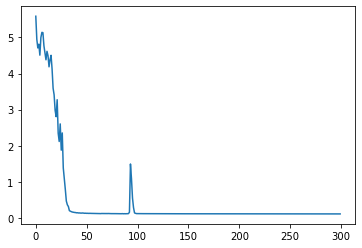

In [697]:
plt.plot(hist)

In [698]:
test = [0] * 21
test[-1] = 113 # start
out = model(np.asarray(test), input_audio[-1].reshape(1, 1,-1), cuda=True)

In [699]:
torch.argmax(out,axis=1)

tensor([3], device='cuda:0', grad_fn=<NotImplemented>)

In [700]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [701]:
token.word_index

{'start': 1,
 'end': 2,
 'the': 3,
 'and': 4,
 'my': 5,
 'to': 6,
 'in': 7,
 'you': 8,
 'her': 9,
 'that': 10,
 'this': 11,
 'it': 12,
 'on': 13,
 'he': 14,
 'was': 15,
 'all': 16,
 'me': 17,
 'we': 18,
 'roll': 19,
 'but': 20,
 'so': 21,
 'man': 22,
 'said': 23,
 'like': 24,
 'of': 25,
 'met': 26,
 'fucked': 27,
 'your': 28,
 'can': 29,
 'just': 30,
 'she': 31,
 'is': 32,
 'ill': 33,
 'thats': 34,
 'out': 35,
 'as': 36,
 'sell': 37,
 'from': 38,
 'up': 39,
 'cause': 40,
 'hey': 41,
 'go': 42,
 'tapes': 43,
 'country': 44,
 'now': 45,
 'right': 46,
 'with': 47,
 'got': 48,
 'if': 49,
 'two': 50,
 'need': 51,
 'smoke': 52,
 'take': 53,
 'white': 54,
 'ass': 55,
 'pussy': 56,
 'be': 57,
 'boy': 58,
 'tell': 59,
 'down': 60,
 'know': 61,
 'good': 62,
 'ive': 63,
 'well': 64,
 'colt': 65,
 'zigzags': 66,
 'baby': 67,
 'park': 68,
 'after': 69,
 'dark': 70,
 'tumbleweed': 71,
 'our': 72,
 'rap': 73,
 'songs': 74,
 'here': 75,
 'through': 76,
 'dont': 77,
 'haha': 78,
 'ever': 79,
 'come': 8

In [714]:
in_text_original = "girl"
in_text = in_text_original
genre = 1 #rap

for i in range(max_length):
        sequence = token.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model(sequence, input_audio[genre].reshape(1, 1,-1) , cuda=True)
        pred = np.argmax(pred.cpu().detach().numpy())
        word = word_for_id(pred, token)
        if word is None:
            break
        in_text += ' ' + word
#         if word == 'end':
#             break
in_text

'girl met that ass everybody mouth like hawaiian rock start start start explain that so so said dont start dont drove had start start'

In [715]:
genre = -1 # country
in_text = in_text_original
for i in range(max_length):
        sequence = token.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model(sequence, input_audio[genre].reshape(1, 1,-1) , cuda=True)
        pred = np.argmax(pred.cpu().detach().numpy())
        word = word_for_id(pred, token)
        if word is None:
            break
        in_text += ' ' + word
#         if word == 'end':
#             break
in_text

'girl has it survive was here end so road start my war live her my say start country be sale all start enough bet'

In [351]:
word

In [ ]:
sequence

In [ ]:
input_audio[449]

In [ ]:
word

In [ ]:
np.where(input_audio[0]!= input_audio)

In [ ]:
input_audio[1]